In [1]:
## this model uses equations found in Fuel Cell Fundamentals 3rd Edition for
## PEMFC modeling
#we will use V = E_t - E_o - E_c 
#V is cell voltage, E_t is thermo, E_o is ohmimc losses, E_c is cathode overpotential <br>


In [2]:
import scipy.optimize as opt
from scipy.integrate import quad
from numpy import exp 
from numpy import log
import timeit

In [3]:
t_m = 125
t_A = 350
t_C = 350
#membrane thickness [um], #anode thickness [um], #cathode thickness [um]

p_a = 3
p_c = 3
p_SAT = 0.307
#anode pressure [atm], cathode pressure [atm], vapor saturation pressure [atm]

F = 96485
R = 8.314
#Faraday's constant [C/mol], gas constant [J/mol*K]

T = 343
#FC operating temperature [K]

x_wa = 0.1
x_wd = 0.1 
#water mole fraction for anode and cathode

x_o = 0.19
#oxygen mole fraction at cathode catalyst layer

D_effa = 0.149
D_effc = 0.0295
#effective hydrogen/water diffusivity (anode) [cm^2/s], effective oxygen/water diffusivity (cathode) [cm^2/s]

j_0 = 0.0001
#reference current [A/cm^2]

In [4]:
#E_o or ohmic overpotential calculations
def eqn(variables):
    (a, C) = variables
    
    eqn1 = 14*(p_a/p_SAT)*(x_wa - t_A*0.000001*((a*j*(1/0.0001)*8.314*T)/(2*F*p_a*101325*D_effa*0.0001))) - 4.4*a - C 
    eqn2 = 10 + 4*(p_c/p_SAT)*(x_wd + t_C*0.000001*(((1+a)*j*(1/0.0001)*R*T)/(2*F*p_c*101325*D_effc*0.0001))) - 4.4*a - C*exp((0.000598*j*t_m*0.0001)/(0.00000381))
    return [eqn1, eqn2]

#NOTE: 0.0000001 is the conversion from um to m, (1/0.0001) is conversion from
#cm^2 to m^2, 101325 is for atm to Pa, 0.0001 is converstion from cm^2 to
#m^2)

In [5]:
#now to solve for conductivity profile of the membrane, sigma(z). Equation
#is based off of(6.40) on p.221, it is based on properties of Nafion. f
#represents sigma(z), further, fInt is ASR or area specific resistance
#since f represents sigma(z), ASR or area specific resistance (fInt in MATLAB)

def ASR(z, a, C):
    return 1/((0.005193*(4.4*a + C*exp((0.000598*j*z)/(0.00000381)))- 0.00326)*exp(1268*((1/303)-(1/T))))

In [6]:
#for E_t or theoretical value of FC
def theoreticalPotential():
    return 1.0
#1.0 volts, ideal voltage

In [7]:
#ohmic potential function
def ohmicPotential():
    solution = opt.fsolve(eqn, (.1,1))
    [a , C] = solution
    result = quad(ASR, 0, t_m*0.0001, args = (a, C))
    return result[0]


In [8]:
#cathode overpotential / equation (6.27) p. 217 
#assume alpha (charge transfer coefficient) is 0.5

def cathodicPotential():
    return (((R*T)/(4*0.5*F))*log(j/(j_0*p_c*101300)*1/(x_o-t_C*0.000001*(j*10000*R*T)/(4*F*p_c*101325*D_effc*0.0001))))

In [9]:
#initialization 
j = 0
#current density [a/cm^2]
V = []
#list of voltages after change in current density

for i in range(10000):
    if j == 0:
        V.append(1.0)
        j = j + 0.01
    else: 
        V.append(theoreticalPotential() - ohmicPotential() - cathodicPotential()) 
        j = j + 0.01
        



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity

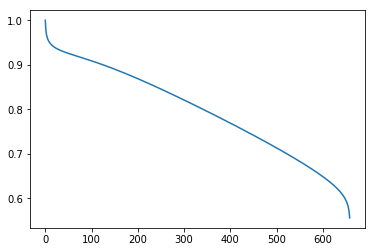

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(V[0:9999])
plt.show()